<a href="https://colab.research.google.com/github/Ryuta2329/Msc-Math-Applied/blob/main/Series%20Temporales/chicken_price_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
install.packages("astsa", quiet=TRUE)
install.packages("cowplot", quiet=TRUE)
install.packages("ggfortify", quiet=TRUE)
install.packages("latex2exp", quiet=TRUE)
install.packages("zoo", quiet=TRUE)
# install.packages("equatiomatic", quiet=TRUE)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘coda’, ‘furrr’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘promises’, ‘broom.mixed’, ‘shiny’




In [14]:
library(astsa, quietly=TRUE, warn.conflicts = FALSE)
library(dplyr, quietly=TRUE, warn.conflicts = FALSE)
library(ggfortify, quietly=TRUE, warn.conflicts = FALSE)

# Precios mensuales del pollo en USA.

Considere el precio mensual (por libra) de un pollo en los EE. UU. desde mediados de 2001 hasta mediados de 2016 (180 meses), digamos $x_t$, que se muestra en la figura siguiente. Hay una tendencia ascendente obvia en la serie, y podríamos usar una regresión lineal simple para estimar esa tendencia ajustando el modelo:

$x_t = \beta_0 + \beta_1 z_t + w_t, \quad z_t = 2001\frac{7}{12}, 2001\frac{8}{12}, \ldots, 2016\frac{6}{12}$.

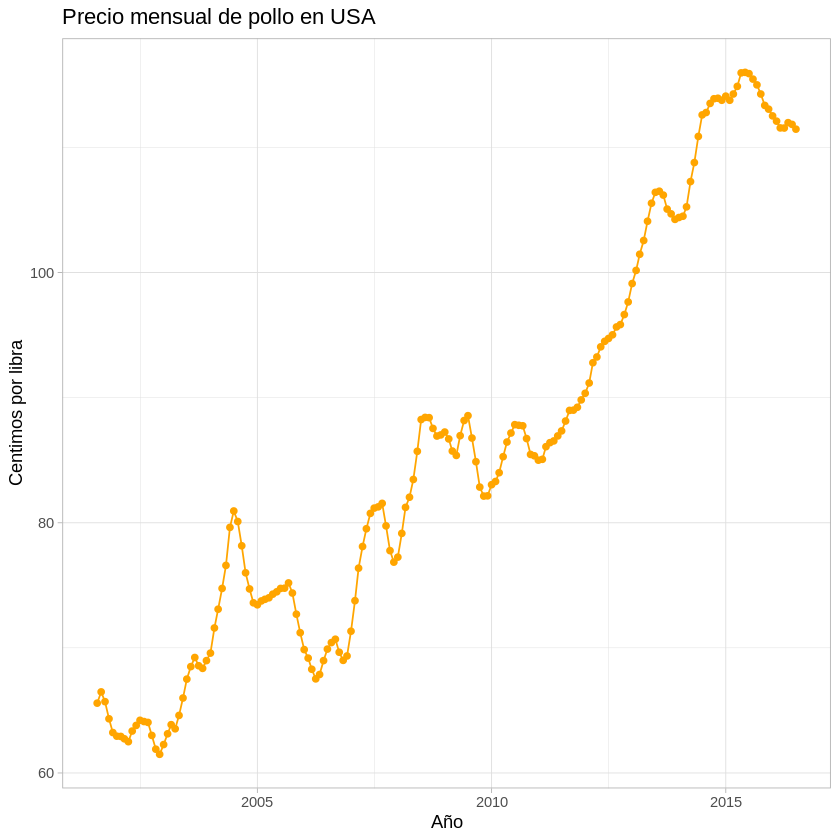

In [50]:
fit <- lm(chicken ~ time(chicken))

autoplot(chicken, colour="orange") + 
  ggtitle("Precio mensual de pollo en USA") +
  aes(y=value) + 
  geom_point(colour="orange") + 
  geom_abline(slope=coef(fit)[[2]], intercept=coef(fit)[[1]], colour="blue") +
  xlab("Año") +
  ylab("Centimos por libra") +
  theme_light()

Esta claro por el grafico donde se muestra el modelo ajustado que, una tendencia solamente no es suficiente para explicar la variacion observada.

Es posible verificar las ACF y PACF para evaluar algun patron de autocorrelacion dentro de la serie o de correlacion residual.

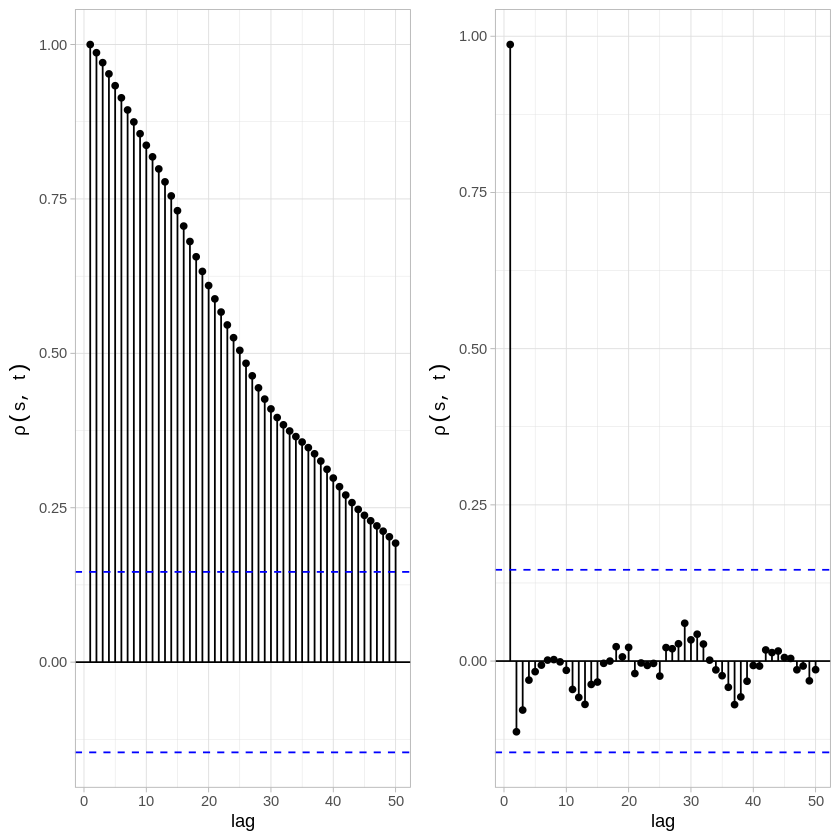

In [16]:
Acf_Pacf_plot <- function(ts_data, max_lag, nrow=1, ncol=2) {
  autocorr_vals <- tibble(lag=1:max_lag,
      acf_vals=acf(ts_data, plot=FALSE, lag=max_lag-1)$acf[,,1], 
      pacf_vals=pacf(ts_data, plot=FALSE, lag=max_lag)$acf[,,1])
      
  cowplot::plot_grid(
      ggplot(autocorr_vals, aes(x=lag, y=acf_vals)) +
          geom_point() +
          geom_hline(aes(yintercept = 0)) +
          geom_segment(mapping = aes(xend = lag, yend = 0)) +
          geom_hline(yintercept = c(1.96/sqrt(length(ts_data)), -1.96/sqrt(length(ts_data))), linetype=2, colour='blue') +
      ylab(latex2exp::TeX("$\\rho(s, t)$")) +
      theme_light(),
      ggplot(autocorr_vals, aes(x=lag, y=pacf_vals)) +
          geom_point() +
          geom_hline(aes(yintercept = 0)) +
          geom_segment(mapping = aes(xend = lag, yend = 0)) +
          geom_hline(yintercept = c(1.96/sqrt(length(ts_data)), -1.96/sqrt(length(ts_data))), linetype=2, colour='blue') +
      ylab(latex2exp::TeX("$\\rho(s, t)$")) +
      theme_light(),
      nrow=nrow, ncol=ncol)
}

Acf_Pacf_plot(chicken, 50)

Se puede observar claramente como la ACF decae lentamente, pero sin caer abruptamente a cero en algun _lag_, mientras que la PACF solo muestra un primer pico significativo, y todos los demas caen por debajo del intervalo de aceptacion $2\sigma_\rho$. Estos resultados parecen indicar que el uso de un modelo $AR(p=1)$ seria apropiado, sobre la serie temporal observada.

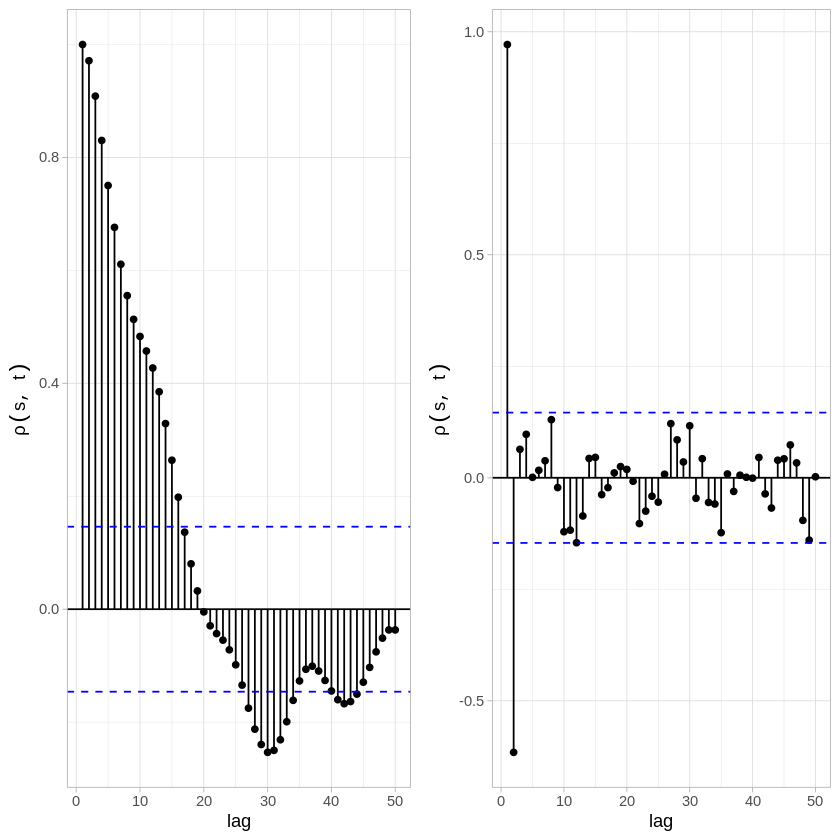

In [17]:

autocorr_vals <- tibble(lag=1:50,
    acf_vals=acf(residuals(fit), plot=FALSE, lag=49)$acf[,,1], 
    pacf_vals=pacf(residuals(fit), plot=FALSE, lag=50)$acf[,,1])
    
cowplot::plot_grid(
    ggplot(autocorr_vals, aes(x=lag, y=acf_vals)) +
        geom_point() +
        geom_hline(aes(yintercept = 0)) +
        geom_segment(mapping = aes(xend = lag, yend = 0)) +
        geom_hline(yintercept = c(1.96/sqrt(length(chicken)), -1.96/sqrt(length(chicken))), linetype=2, color='blue') +
    ylab(latex2exp::TeX("$\\rho(s, t)$")) +
    theme_light(),
    ggplot(autocorr_vals, aes(x=lag, y=pacf_vals)) +
        geom_point() +
        geom_hline(aes(yintercept = 0)) +
        geom_segment(mapping = aes(xend = lag, yend = 0)) +
        geom_hline(yintercept = c(1.96/sqrt(length(chicken)), -1.96/sqrt(length(chicken))), linetype=2, color='blue') +
    ylab(latex2exp::TeX("$\\rho(s, t)$")) +
    theme_light(),
    nrow=1)

Sin embargo, un mismo analisis sobre los residuales del modelo con tendencia, ajustado previamente, muestra que el modelo debería ser $ARIMA(p=2,d=1,0)$, dado los dos picos significativos en la PACF y el decaimiento lento de la ACF, y para corregir por estacionaridad dado que se pueden observar al menos tres niveles de media distinta en el gráfico de residuales (figura siguiente).
Además, parece haber un comportamiento cíclico fluctuante en la serie que en este modelo no se está tomando en cuenta porque se ve oscurecido por la falta de estacionaridad de la serie.

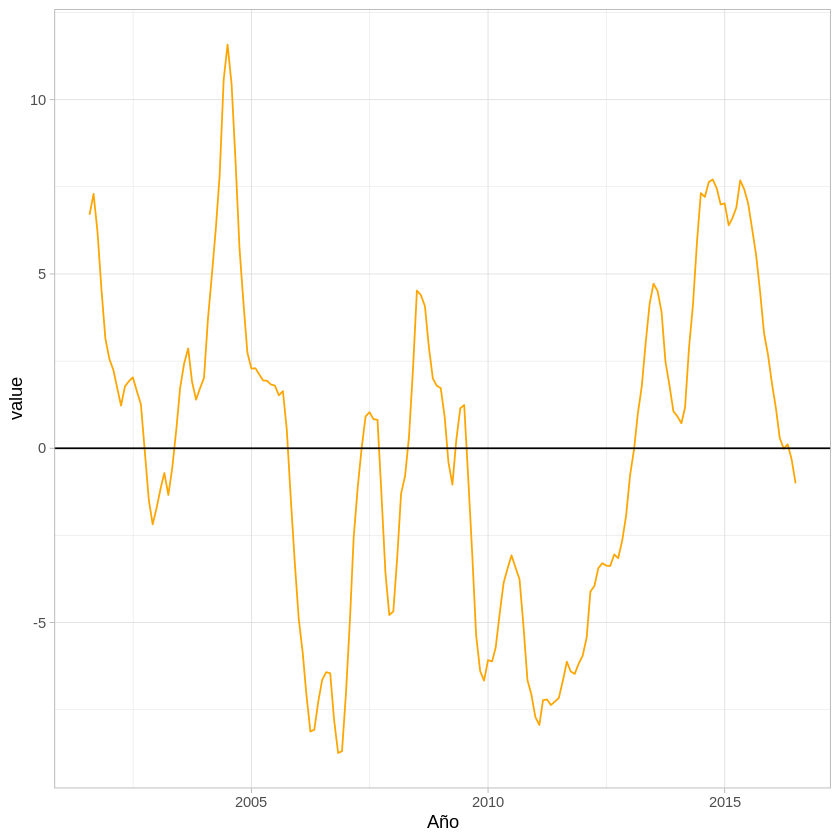

In [18]:
autoplot(ts(residuals(fit), start=start(chicken), frequency=frequency(chicken)), colour="orange") +
  xlab("Año") +
  ylab("Residuales") +
  aes(y=value) +
  geom_hline(yintercept=0) +
  theme_light()

Se ajusta primero el modelo $AR(2)$ y $ARIMA(2,1,0)$ a los residuales para verificar cuál de estos resulta más apropiado para los datos, o si se deben considerar otros parámetros.

Los resultados mostrados a continuación indican que el modelo con diferencia de primer orden es preferible por sobre el modelo $AR(2)$ puro, pero la diferencia entre ambos es muy baja.

In [19]:
fit_residuals_1 <- arima(residuals(fit),
  order=c(2L, 0, 0))
fit_residuals_2 <- arima(residuals(fit),
  order=c(2L, 1L, 0))

In [20]:
# Resultados del ajuste: estadísticos de bondad de ajuste. 
list(fit_residuals_1,fit_residuals_2) %>% 
  purrr::map(broom::glance) %>%
  bind_rows

sigma,logLik,AIC,BIC,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.6610103,-183.2415,374.4829,387.2548,180
0.6548222,-178.6775,363.3550,372.9172,179


Al comprobar el gráfico de residuales y las funciones de autocorrelación observamos que el modelo con diferencia de primer orden se distribuye mejor alrededor del cero (esto es, hay menos desviaciones con respecto a la estacionaridad de los residuales). 
Sin embargo, en ambos graficos de residuales es posible aun observar un comportameinto sinusoidal, indicando el comportamiento estacional no tomado en cuenta. De hecho, es posible observar en la ACF el mismo comportamiento sinusoidal. 

Además, se nota de inmediato la presencia de retrasos significativos en la ACF y PACF de ambos modelos, particularmente, se opbsera un componente periódico $m=12$, por lo que se concluye que debe de existir un componenete estacional con orden $P=1$ y $Q=1$.

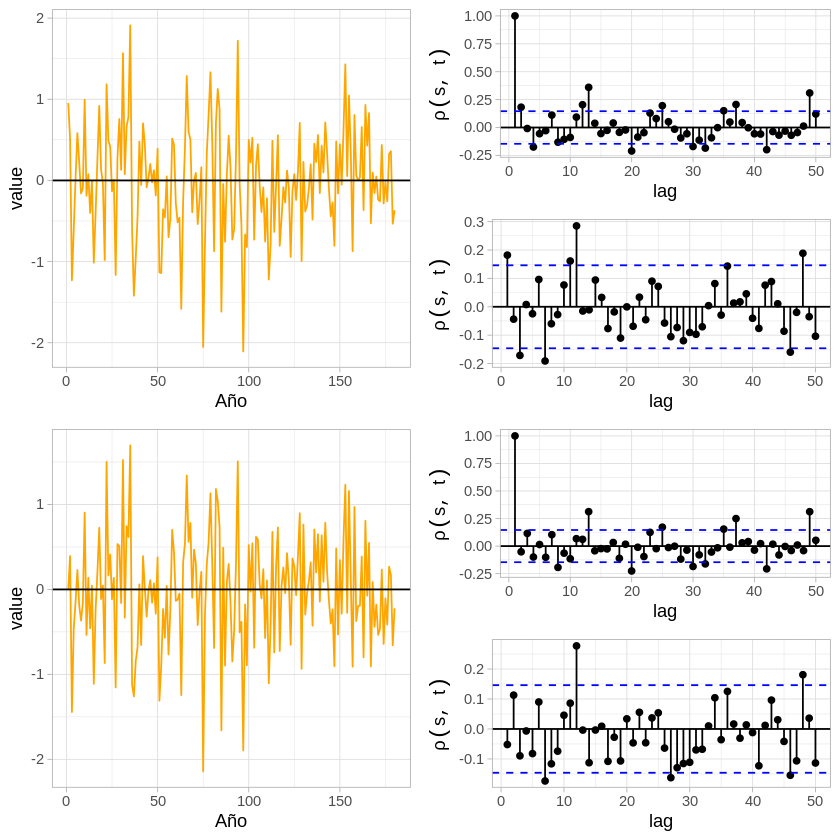

In [21]:

cowplot::plot_grid(
  cowplot::plot_grid(
    autoplot(residuals(fit_residuals_1), colour="orange") +
      xlab("Año") +
      ylab("Residuales") +
      aes(y=value) +
      geom_hline(yintercept=0) +
      theme_light(),
    autoplot(residuals(fit_residuals_2), colour="orange") +
      xlab("Año") +
      ylab("Residuales") +
      aes(y=value) +
      geom_hline(yintercept=0) +
      theme_light(), 
    nrow=2),
cowplot::plot_grid(
  Acf_Pacf_plot(residuals(fit_residuals_1), 50, nrow=2, ncol=1),
  Acf_Pacf_plot(residuals(fit_residuals_2), 50, nrow=2, ncol=1), 
  nrow=2
), 
nrow=1)

Ajustando ahora un nuevo modelo, $SARIMA(2, 1, 0)(1, 0, 1)_{12}$, es visible en los resultados de los estadísticos de bondad de ajuste que este modelo es preferible por encima de los dos modelos ajustados anteriormente, dada la menor varianza residual y $AIC$. 

In [30]:
fit_sarima <- arima(residuals(fit),
  order=c(2L, 1L, 0),
  seasonal=list(order=c(1L, 0L, 1L), period=12))

broom::glance(fit_sarima)

sigma,logLik,AIC,BIC,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.5716875,-159.1207,328.2414,344.1783,179


Al observar el gráfico  de residuales, es claro que los residuales del modelo se comportan como ruido blanco en torno a su media 0, aunque aún es visible el comportamiento sinusoidal en la serie. Aunque se observan un par de puntos significativos en la PACF y ACF, estos son apenas marginales, por lo que se concluye que el modelo ajusta bien la serie temporal observada.

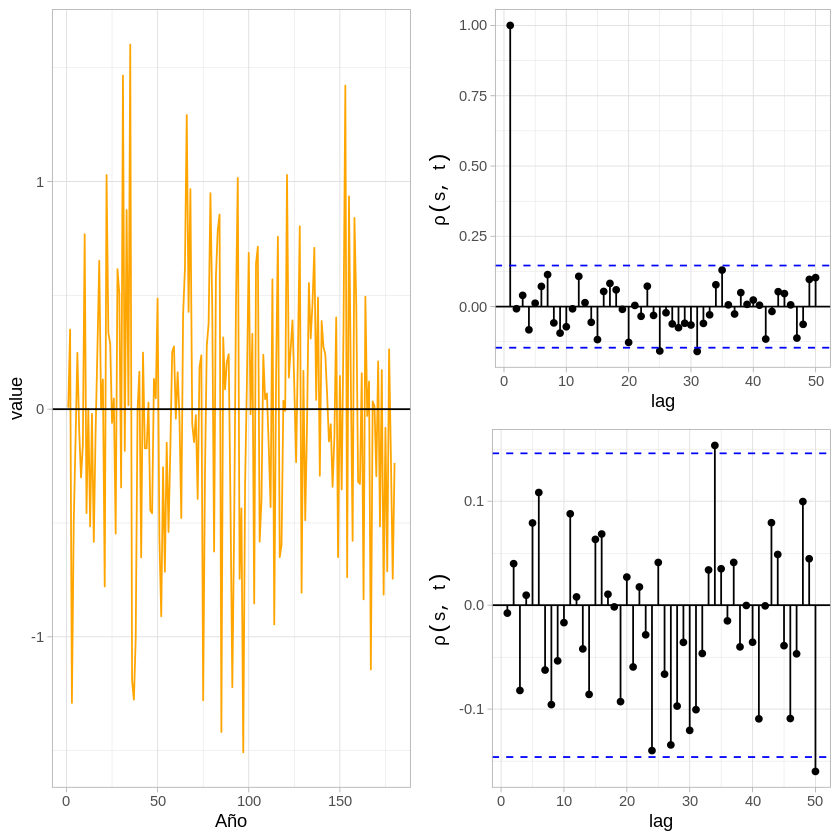

In [53]:
cowplot::plot_grid(
    autoplot(residuals(fit_sarima), colour="orange") +
      xlab("Año") +
      ylab("Residuales") +
      aes(y=value) +
      geom_hline(yintercept=0) +
      theme_light(),
  Acf_Pacf_plot(residuals(fit_sarima), 50, nrow=2, ncol=1), 
  nrow=1
)

Una vez seleccionado el modelo basado en los residuales, se aplica el mismo sobre la serie temporal original ```chicken```, usando como regresor el tiempo para tomar en cuenta el componente de tendencia.

Se nota que se quitó del modelo final la diferencia de primer orden, dado que la diferencia de este con respecto al modelo con $d=1$ es mínima en términos de los estadísticos; de forma que el modelo ajustara bien la serie en su totalidad, incluyendo la primera observación. 


In [65]:
fit_sarima_chicken <- arima(chicken,
  order=c(2L, 0L, 0),
  seasonal=list(order=c(1L, 0L, 1L), period=12),
  xreg=time(chicken))

broom::glance(fit_sarima_chicken)

sigma,logLik,AIC,BIC,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.571718,-161.4657,336.9314,359.2821,180


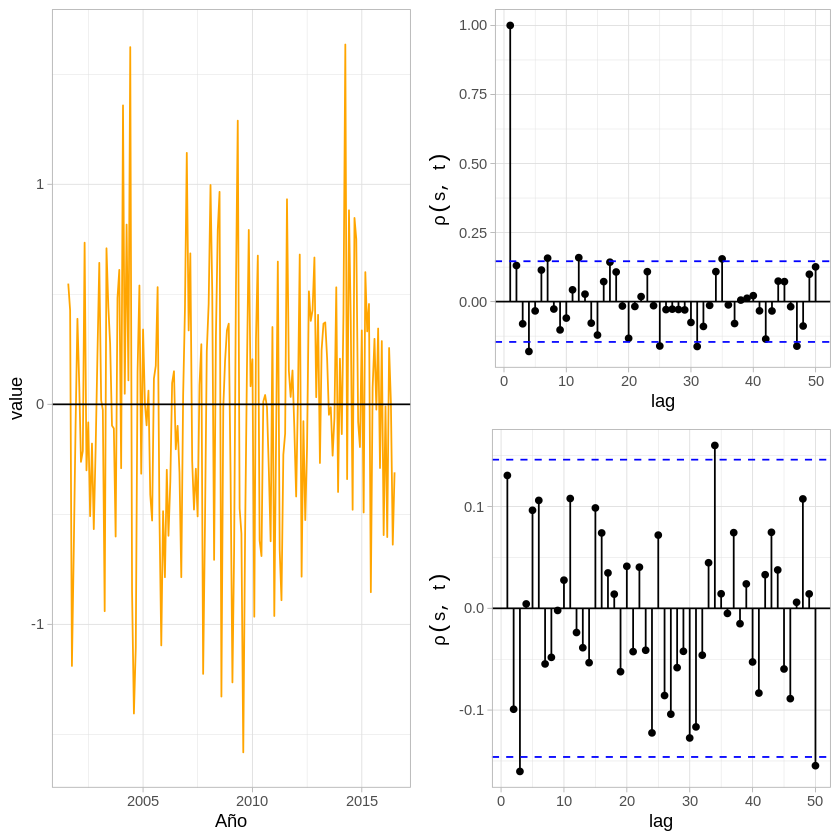

In [66]:
cowplot::plot_grid(
    autoplot(residuals(fit_sarima_chicken), colour="orange") +
      xlab("Año") +
      ylab("Residuales") +
      aes(y=value) +
      geom_hline(yintercept=0) +
      theme_light(),
  Acf_Pacf_plot(residuals(fit_sarima_chicken), 50, nrow=2, ncol=1), 
  nrow=1
)

El grafico de residuales muestra nuevamente que la serie de residuales parece seguir un ruido blanco que se distribuye alrededor de un valor medio con comportamiento sinusoidal. 
Este componenete no tomado en cuenta en la serie parece tener un efecto importante en las funciones de autocorrelación, donde se observa (principalmente en la ACF) como varios puntos son significativos, alternando por encima y por debajo del eje horizontal.